## Opening the black box of MCMC

### The Bayesian landscape

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the *surface*, or *curve*, that sits on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely). 

In [2]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import arviz as az
import matplotlib as mt
mt.style.use("ggplot")
import numpy as np
import pandas as pd
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet

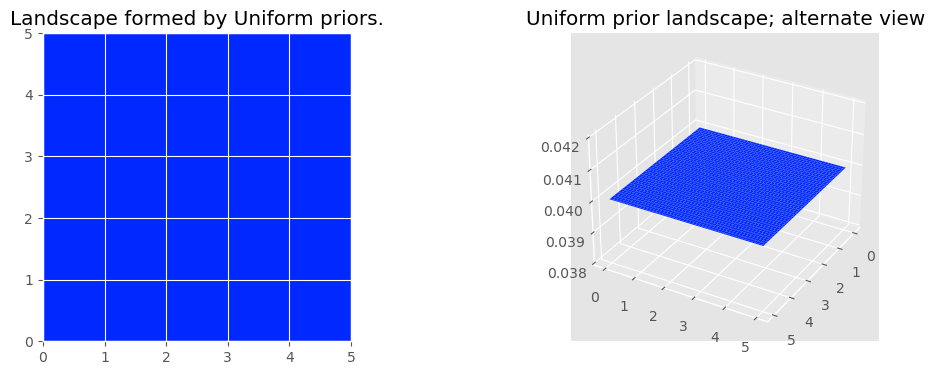

In [3]:

fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");


### NOTE:  Why Multiply Two Unidimensional PDFs in a 2D Problem?

Suppose we have two independent random variables:

- $ X \sim \text{Uniform}(0, 5) $
- $ Y \sim \text{Uniform}(0, 5) $

#### Joint PDF for Independent Variables

When two random variables are independent, the **joint probability density function (PDF)** is the **product** of their individual PDFs:

$
f_{X,Y}(x, y) = f_X(x) \cdot f_Y(y)
$
This holds true for any pair of independent continuous variables — it’s a fundamental rule in probability theory.

#### Applying to Uniform(0, 5)

The PDF of a Uniform distribution on \([0, 5]\) is:
$
f_X(x) = f_Y(y) =
\begin{cases}
\frac{1}{5} & \text{if } 0 \le x \le 5 \\
0 & \text{otherwise}
\end{cases}
$

So the joint PDF becomes:
$
f_{X,Y}(x, y) =
\begin{cases}
\frac{1}{25} & \text{if } 0 \le x \le 5 \text{ and } 0 \le y \le 5 \\
0 & \text{otherwise}
\end{cases}
$

Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers. 

The plots below visualize this. The more dark red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location. 

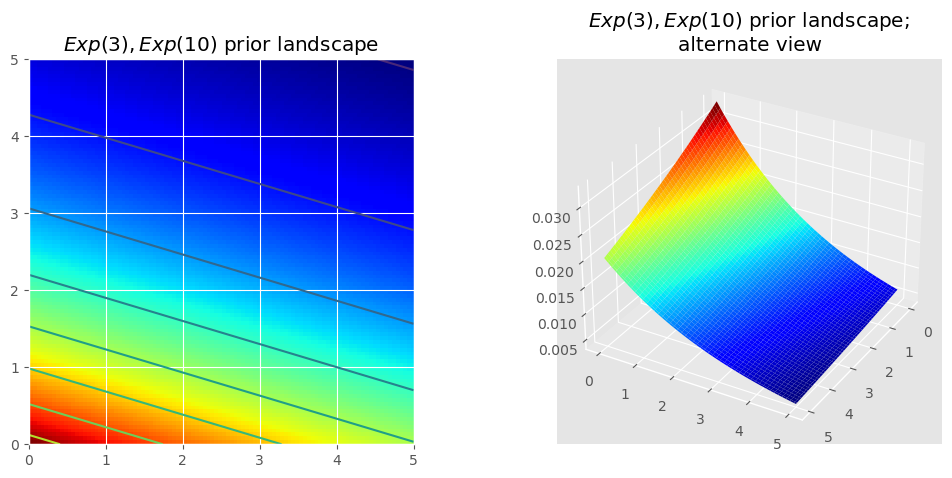

In [9]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");


These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional. 

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present.  Regardless, the resulting surface describes the *posterior distribution*. 

Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially *pushes up* the original surface to make *tall mountains*. The tendency of the observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there. 

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape: 

## Keep in mind this example scenario: Emergency Room (ER) Patient Arrivals

Imagine a hospital's emergency room receives:

- **Walk-in patients** at an average rate of **5 per hour** $(\mu_1 = 1)$.
- **Ambulance arrivals** at an average rate of **2 per hour** $(\mu_2 = 3)$.


![Bayesian Graph](./images/Bayesian_graph_01.png)


In [11]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
# L has shape (100,100)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])


observed (2-dimensional,sample size = 1): [[1 6]]


In [12]:
print(likelihood_x[0:20])
print(likelihood_x.shape)


[0.0099005  0.0568634  0.09918548 0.13720949 0.17125573 0.20162336
 0.22859178 0.25242177 0.27335673 0.29162367 0.30743432 0.320986
 0.3324626  0.34203538 0.34986376 0.35609612 0.36087043 0.36431498
 0.36654896 0.36768307]
(100,)


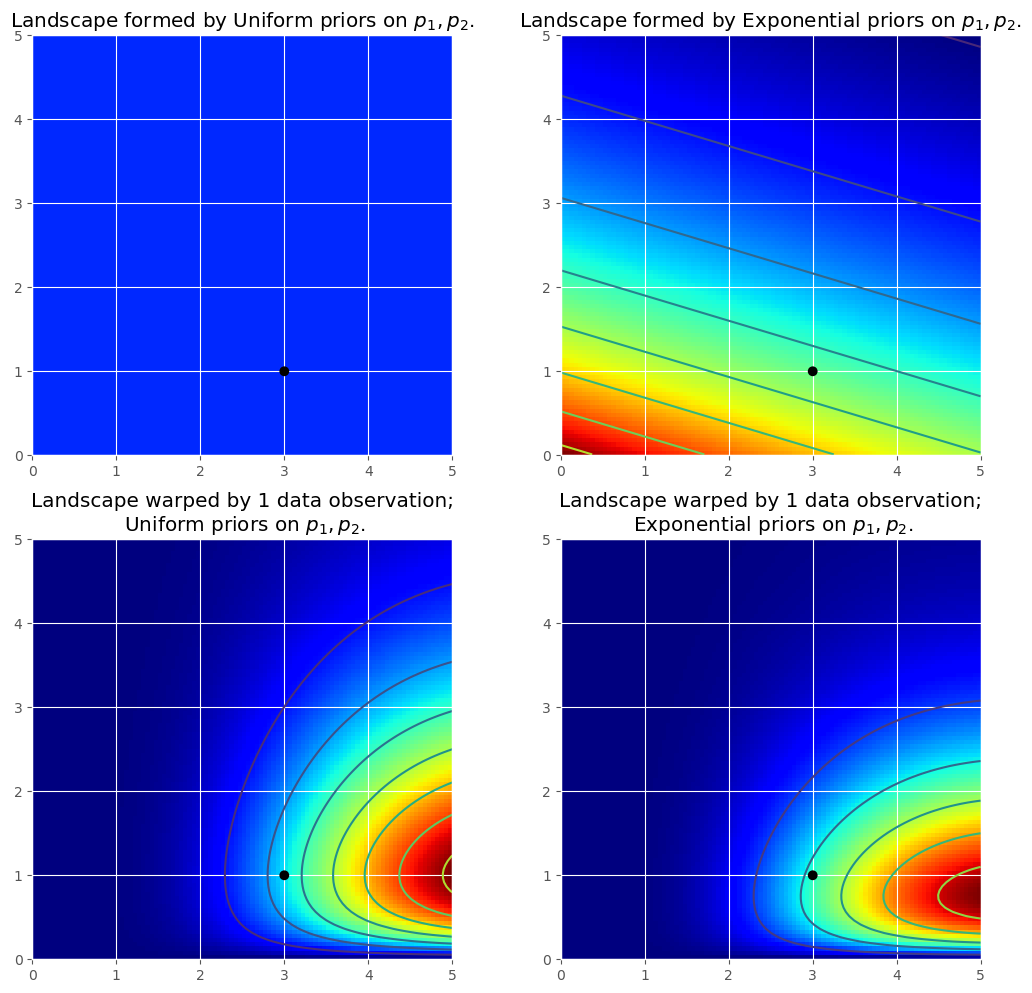

In [ ]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
# the distributions are independent, the join distribution is the multiplication
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
# bayes theorem: posterior is proportional to the prior*likelihood
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


The plot on the left is the deformed landscape with the $\text{Uniform}(0,5)$ priors, and the plot on the right is the deformed landscape with the exponential priors. Notice that the posterior landscapes look different from one another, though the data observed is identical in both cases. The reason is as follows. Notice the exponential-prior landscape, bottom right figure, puts very little *posterior* weight on values in the upper right corner of the figure: this is because *the prior does not put much weight there*. On the other hand, the uniform-prior landscape is happy to put posterior weight in the upper-right corner, as the prior puts more weight there. 

Notice also the highest-point, corresponding the the darkest red, is biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The black dot represents the true parameters. Even with 1 sample point, the mountains attempts to contain the true parameter. Of course, inference with a sample size of 1 is incredibly naive, and choosing such a small sample size was only illustrative. 

It's a great exercise to try changing the sample size to other values (try 2,5,10,100?...) and observing how our "mountain" posterior changes. 

In [ ]:
def draw_surfices(N, lambda_1_true, lambda_2_true):

    #...we see the data generated, dependent on the above two values.
    data = np.concatenate([
        stats.poisson.rvs(lambda_1_true, size=(N, 1)),
        stats.poisson.rvs(lambda_2_true, size=(N, 1))
    ], axis=1)
    #print("observed (2-dimensional,sample size = %d):" % N, data)

    # plotting details.
    x = y = np.linspace(.01, 5, 100)
    likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                            for _x in x]).prod(axis=1)
    likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                            for _y in y]).prod(axis=1)
    # L has shape (100,100)
    L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

    figsize(12.5, 12)
    # matplotlib heavy lifting below, beware!
    plt.subplot(221)
    uni_x = stats.uniform.pdf(x, loc=0, scale=5)
    uni_y = stats.uniform.pdf(x, loc=0, scale=5)
    M = np.dot(uni_x[:, None], uni_y[None, :])
    im = plt.imshow(M, interpolation='none', origin='lower',
                    cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
    plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

    plt.subplot(223)
    plt.contour(x, y, M * L)
    im = plt.imshow(M * L, interpolation='none', origin='lower',
                    cmap=jet, extent=(0, 5, 0, 5))
    plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
    plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
    plt.xlim(0, 5)
    plt.ylim(0, 5)

    plt.subplot(222)
    exp_x = stats.expon.pdf(x, loc=0, scale=3)
    exp_y = stats.expon.pdf(x, loc=0, scale=10)
    M = np.dot(exp_x[:, None], exp_y[None, :])

    plt.contour(x, y, M)
    im = plt.imshow(M, interpolation='none', origin='lower',
                    cmap=jet, extent=(0, 5, 0, 5))
    plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

    plt.subplot(224)
    # This is the likelihood times prior, that results in the posterior.
    plt.contour(x, y, M * L)
    im = plt.imshow(M * L, interpolation='none', origin='lower',
                    cmap=jet, extent=(0, 5, 0, 5))

    plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
    plt.title("Landscape warped by %d data observation;\n Exponential priors on \
    $p_1, p_2$." % N)
    plt.xlim(0, 5)
    plt.ylim(0, 5);

In [ ]:
# run the same experiment with 5,10 and 100 datapoints

### Exploring the landscape using the MCMC

We should explore the deformed posterior space generated by our prior surface and observed data to find the posterior mountain. However, we cannot naively search the space: any computer scientist will tell you that traversing $N$-dimensional space is exponentially difficult in $N$: the size of the space quickly blows-up as we increase $N$ (see [the curse of dimensionality](http://en.wikipedia.org/wiki/Curse_of_dimensionality)). What hope do we have to find these hidden mountains? The idea behind MCMC is to perform an intelligent search of the space. To say "search" implies we are looking for a particular point, which is perhaps not an accurate as we are really looking for a broad mountain. 

Recall that MCMC returns *samples* from the posterior distribution, not the distribution itself. Stretching our mountainous analogy to its limit, MCMC performs a task similar to repeatedly asking  "How likely is this pebble I found to be from the mountain I am searching for?", and completes its task by returning thousands of accepted pebbles in hopes of reconstructing the original mountain. In MCMC and PyMC lingo, the returned sequence of "pebbles" are the samples,  cumulatively called the *traces*. 

When I say MCMC intelligently searches, I really am saying MCMC will *hopefully* converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. Again, perhaps "converge" is not an accurate term to describe MCMC's progression. Converging usually implies moving towards a point in space, but MCMC moves towards a *broader area* in the space and randomly walks in that area, picking up samples from that area.

#### Why Thousands of Samples?

At first, returning thousands of samples to the user might sound like being an inefficient way to describe the posterior distributions. I would argue that this is extremely efficient. Consider the alternative possibilities:

1. Returning a mathematical formula for the "mountain ranges" would involve describing a N-dimensional surface with arbitrary peaks and valleys.
2. Returning the "peak" of the landscape, while mathematically possible and a sensible thing to do as the highest point corresponds to most probable estimate of the unknowns, ignores the shape of the landscape, which we have previously argued is very important in determining posterior confidence in unknowns. 

Besides computational reasons, likely the strongest reason for returning samples is that we can easily use *The Law of Large Numbers* to solve otherwise intractable problems. With the thousands of samples, we can reconstruct the posterior surface by organizing them in a histogram. 

#### Markov Chain Property ####

A Markov chain is a stochastic process that satisfies the Markov property: the probability of transitioning to a future state depends only on the current state and not on the sequence of states that preceded it. Mathematically, if we denote the state at time t as $X_t$, the Markov property can be expressed as:

$P(X_{t+1} = x | X_t = x_t, X_{t-1} = x_{t-1}, ..., X_0 = x_0) = P(X_{t+1} = x | X_t = x_t)$

This "memoryless" property makes Markov chains mathematically tractable while still allowing them to model complex systems.

Several key properties of Markov chains are relevant to MCMC methods:

1. **Irreducibility**: A Markov chain is irreducible if it is possible to get from any state to any other state in a finite number of steps. This ensures that the chain can explore the entire state space.

2. **Aperiodicity**: A state is aperiodic if the chain can return to it at irregular times. A chain is aperiodic if all its states are aperiodic. This prevents the chain from getting stuck in cycles.

3. **Positive recurrence**: A state is positive recurrent if the expected return time to that state is finite. This ensures that the chain doesn't drift off to infinity.

A Markov chain that is irreducible, aperiodic, and positive recurrent is said to be **ergodic**. Ergodic chains have a unique stationary distribution π, such that if $X_t$ has distribution $π$, then $X_{t+1}$ also has distribution π. In other words, once the chain reaches its stationary distribution, it remains there.

The fundamental idea behind MCMC methods is to construct a Markov chain whose stationary distribution is the posterior distribution we're interested in. By running this chain for a sufficiently long time, we can generate samples from the posterior distribution, which can then be used to compute expectations, quantiles, and other quantities of interest.


### Algorithms to perform MCMC

There is a large family of algorithms that perform MCMC. Most of these algorithms can be expressed at a high level as follows: 

1. Start at current position.
2. Propose moving to a new position
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions 
4.  1.  If you accept: Move to the new position. Return to Step 1.
    2. Else: Do not move to new position. Return to Step 1. 
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution. 

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions *that are likely not from the posterior* but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior.

In the above algorithm's pseudocode, notice that only the current position matters (new positions are investigated only near the current position). We can describe this property as *memorylessness*, i.e. the algorithm does not care *how* it arrived at its current position, only that it is there. 

### Other approximation solutions to the posterior
Besides MCMC, there are other procedures available for determining the posterior distributions. A Laplace approximation is an approximation of the posterior using simple functions. A more advanced method is [Variational Bayes](http://en.wikipedia.org/wiki/Variational_Bayesian_methods). All three methods, Laplace Approximations, Variational Bayes, and classical MCMC have their pros and cons. 

### MCMC Algorithms: Metropolis-Hastings, Gibbs Sampling

**Metropolis-Hastings Algorithm**

The Metropolis-Hastings algorithm, developed by Nicholas Metropolis in 1953 and generalized by W. Keith Hastings in 1970, is one of the most fundamental MCMC methods. It provides a general framework for constructing a Markov chain that converges to a specified target distribution.

The algorithm proceeds as follows:


1. Initialize the chain at a starting point $θ_0$.

2. For each iteration $t = 1, 2, \dots$:

   a. Propose a new state $θ'$ from a proposal distribution $q(θ'|θ_{t-1})$.

   b. Calculate the acceptance ratio:

   $$
   α = \min\left(1, \frac{p(θ')p(data|θ')}{p(θ_{t-1})p(data|θ_{t-1})} \right)
   $$

   where $p(θ)$ is proportional to the target distribution.

   c. Accept the proposed state with probability $α$:

   - $θ_t = θ'$ with probability $α$  
   - $θ_t = θ_{t-1}$ with probability $1 - α$



The beauty of the Metropolis-Hastings algorithm is that it only requires the ability to evaluate the target distribution up to a proportionality constant. This is particularly useful in Bayesian inference, where the normalizing constant of the posterior distribution (the marginal likelihood) is often difficult to compute.

The choice of proposal distribution q(θ'|θ) is crucial for the efficiency of the algorithm. If the proposal distribution is too narrow, the chain will explore the space slowly and may get stuck in local modes. If it's too wide, most proposals will be rejected, also leading to inefficient exploration. Finding a good proposal distribution often requires problem-specific knowledge and tuning.

**Gibbs Sampling**

Gibbs sampling, introduced by Stuart and Donald Geman in 1984, is a special case of the Metropolis-Hastings algorithm where the proposal distribution is chosen to be the conditional distribution of one variable given all others. This choice leads to an acceptance probability of 1, meaning that all proposals are accepted.

The Gibbs sampling algorithm proceeds as follows:

1. Initialize the chain at a starting point $θ_0 = (θ_0^1, θ_0^2, \dots, θ_0^d)$.

2. For each iteration $t = 1, 2, \dots$:

   a. For each component $j = 1, 2, \dots, d$:

      i. Sample $θ_t^j$ from the conditional distribution  
      $p(θ^j \mid θ_t^1, \dots, θ_t^{j-1}, θ_{t-1}^{j+1}, \dots, θ_{t-1}^d)$.


Gibbs sampling is particularly effective when the conditional distributions are easy to sample from, which is often the case for models with conjugate priors. However, it can be inefficient when there are strong correlations between parameters, as it only updates one parameter at a time.

Both the Metropolis-Hastings algorithm and Gibbs sampling have been foundational in the development of MCMC methods and continue to be widely used in practice. They form the basis for more advanced algorithms like Hamiltonian Monte Carlo and the No-U-Turn Sampler, which we will explore in the next class.

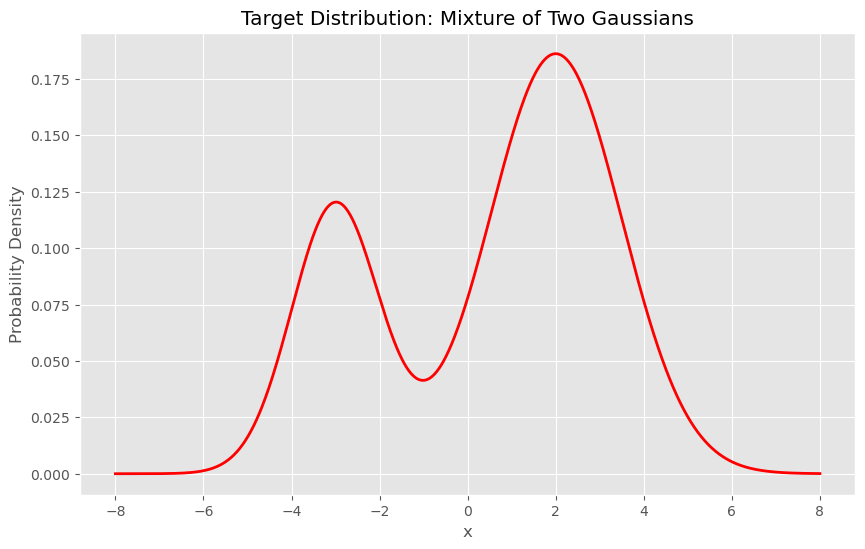

In [12]:
# Define the target distribution (unnormalized)
def target_pdf(x):
    """Unnormalized PDF of a mixture of two Gaussians."""
    return 0.3 * stats.norm.pdf(x, -3, 1) + 0.7 * stats.norm.pdf(x, 2, 1.5)

# Plot the target distribution
x = np.linspace(-8, 8, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, target_pdf(x), 'r-', lw=2)
plt.title('Target Distribution: Mixture of Two Gaussians')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

In [13]:
def metropolis_hastings(target, proposal_width, n_samples, initial_value=0):
    """
    Metropolis-Hastings algorithm for sampling from a target distribution.
    
    Parameters:
    -----------
    target : function
        Unnormalized target PDF
    proposal_width : float
        Standard deviation of the Gaussian proposal distribution
    n_samples : int
        Number of samples to generate
    initial_value : float
        Starting point for the chain
        
    Returns:
    --------
    samples : array
        Generated samples
    acceptance_rate : float
        Fraction of proposals that were accepted
    """
    samples = np.zeros(n_samples)
    current = initial_value
    n_accepted = 0
    
    for i in range(n_samples):
        # Propose a new value
        proposal = current + np.random.normal(0, proposal_width)
        
        # Calculate acceptance probability
        current_log_prob = np.log(target(current) + 1e-10)  # Add small constant to avoid log(0)
        proposal_log_prob = np.log(target(proposal) + 1e-10)
        acceptance_prob = np.exp(proposal_log_prob - current_log_prob)
        
        # Accept or reject
        if np.random.random() < acceptance_prob:
            current = proposal
            n_accepted += 1
            
        samples[i] = current
        
    acceptance_rate = n_accepted / n_samples
    return samples, acceptance_rate

Acceptance rate: 0.81


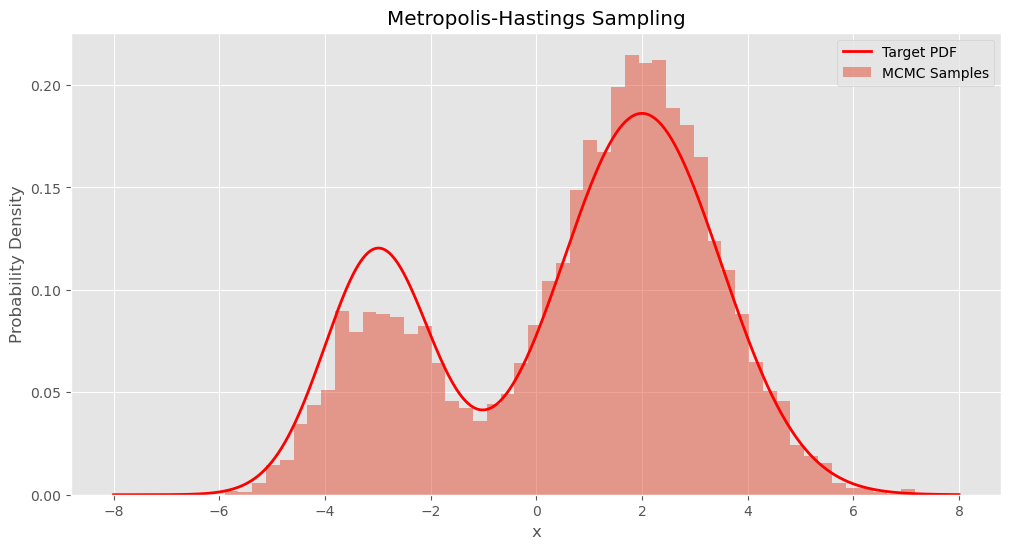

In [14]:
# Run the sampler
np.random.seed(42)
samples, acceptance_rate = metropolis_hastings(target_pdf, 1.0, 10000)

print(f"Acceptance rate: {acceptance_rate:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the target distribution
x = np.linspace(-8, 8, 1000)
plt.plot(x, target_pdf(x), 'r-', lw=2, label='Target PDF')

# Plot the histogram of samples
plt.hist(samples, bins=50, density=True, alpha=0.5, label='MCMC Samples')

plt.title('Metropolis-Hastings Sampling')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

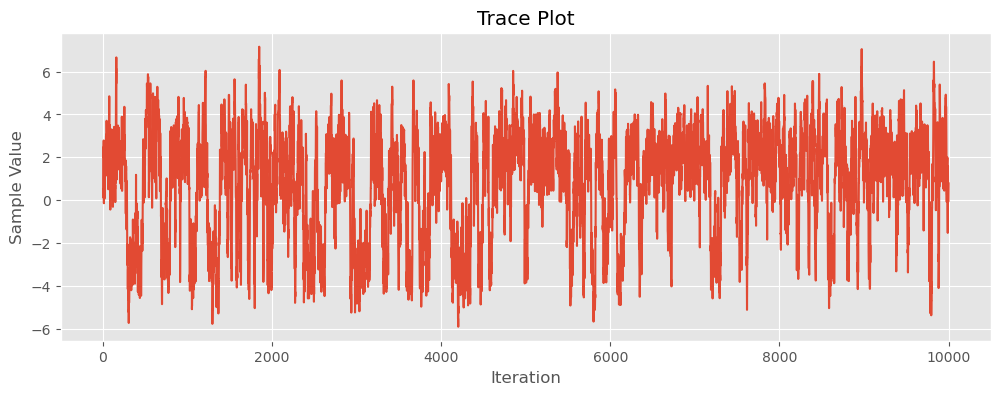

In [15]:
# Trace plot
plt.figure(figsize=(12, 4))
plt.plot(samples)
plt.title('Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.show()

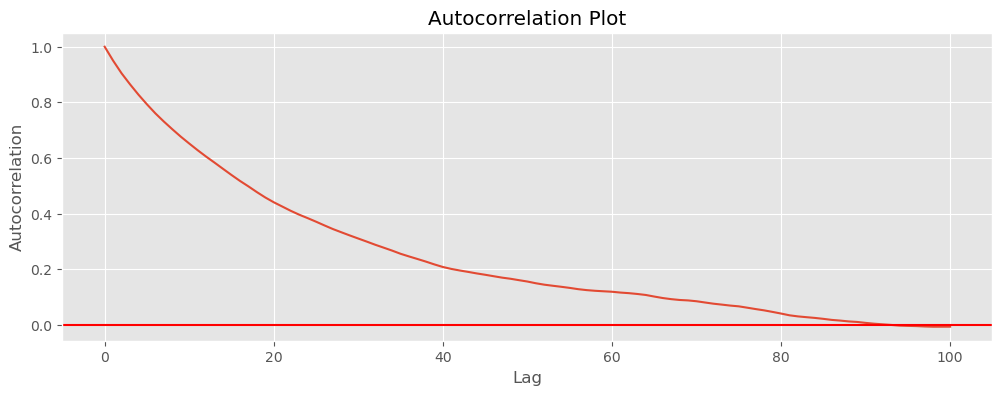

In [16]:
# Autocorrelation plot
def autocorrelation(x, max_lag=100):
    """Compute autocorrelation of a time series."""
    n = len(x)
    mean = np.mean(x)
    var = np.var(x)
    
    acorr = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        c = np.sum((x[:n-lag] - mean) * (x[lag:] - mean)) / (n - lag)
        acorr[lag] = c / var
        
    return acorr

acorr = autocorrelation(samples)
plt.figure(figsize=(12, 4))
plt.plot(acorr)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

### How much important is the distribution of the proposal

Experiment with different proposal widths for the Metropolis-Hastings algorithm. Try values like 0.1, 1.0, and 5.0. How does the proposal width affect the acceptance rate and the quality of the samples?

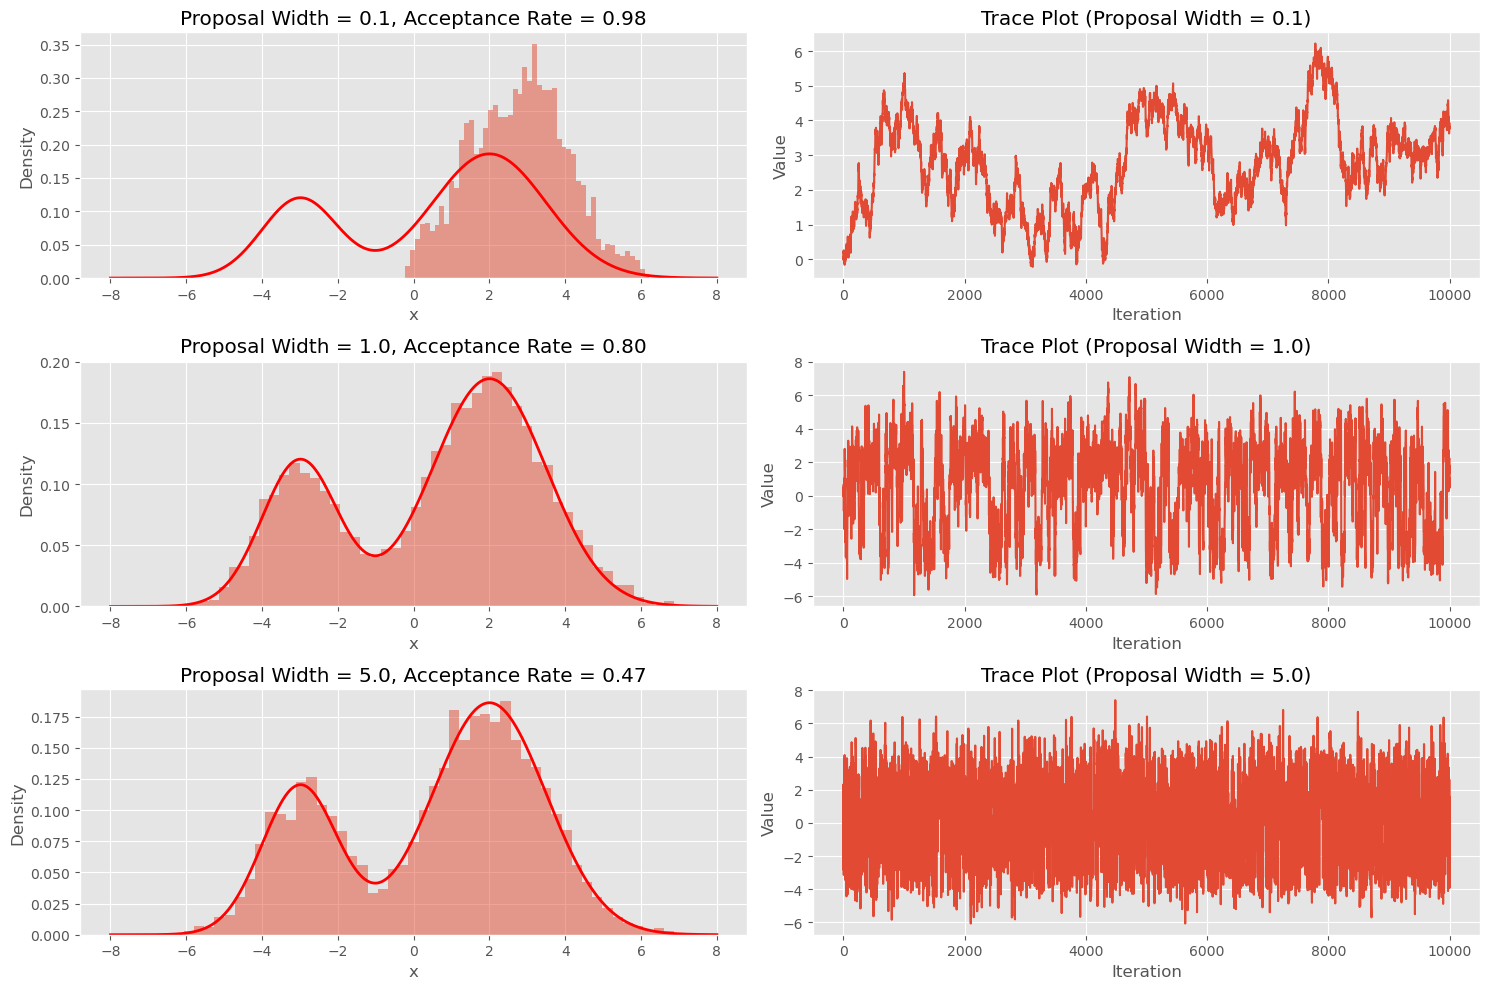

In [17]:
# Your code here
proposal_widths = [0.1, 1.0, 5.0]
np.random.seed(42)

plt.figure(figsize=(15, 10))

for i, width in enumerate(proposal_widths):
    samples, acceptance_rate = metropolis_hastings(target_pdf, width, 10000)
    
    # Plot histogram
    plt.subplot(3, 2, 2*i+1)
    plt.hist(samples, bins=50, density=True, alpha=0.5)
    plt.plot(x, target_pdf(x), 'r-', lw=2)
    plt.title(f'Proposal Width = {width}, Acceptance Rate = {acceptance_rate:.2f}')
    plt.xlabel('x')
    plt.ylabel('Density')
    
    # Plot trace
    plt.subplot(3, 2, 2*i+2)
    plt.plot(samples)
    plt.title(f'Trace Plot (Proposal Width = {width})')
    plt.xlabel('Iteration')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

Now, let's implement a Gibbs sampler for a bivariate normal distribution with correlation.

In [18]:
def gibbs_bivariate_normal(n_samples, rho, initial_values=None):
    """
    Gibbs sampler for a bivariate normal distribution with correlation rho.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    rho : float
        Correlation coefficient (-1 <= rho <= 1)
    initial_values : tuple
        Starting point (x, y) for the chain
        
    Returns:
    --------
    samples : array
        Generated samples with shape (n_samples, 2)
    """
    if initial_values is None:
        initial_values = (0, 0)
        
    samples = np.zeros((n_samples, 2))
    x, y = initial_values
    
    for i in range(n_samples):
        # Sample x conditional on y
        x = np.random.normal(rho * y, np.sqrt(1 - rho**2))
        
        # Sample y conditional on x
        y = np.random.normal(rho * x, np.sqrt(1 - rho**2))
        
        samples[i] = [x, y]
        
    return samples

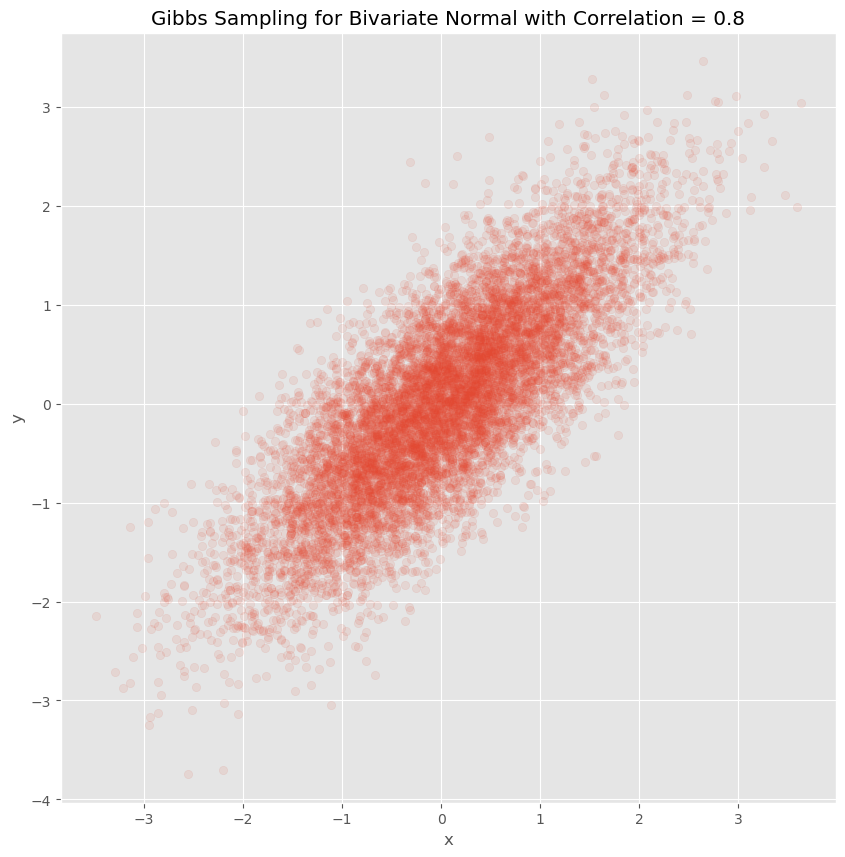

In [19]:
# Run the Gibbs sampler
np.random.seed(42)
samples_gibbs = gibbs_bivariate_normal(10000, 0.8)

# Plot the results
plt.figure(figsize=(10, 10))

# Scatter plot of samples
plt.scatter(samples_gibbs[:, 0], samples_gibbs[:, 1], alpha=0.1)
plt.title('Gibbs Sampling for Bivariate Normal with Correlation = 0.8')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.show()

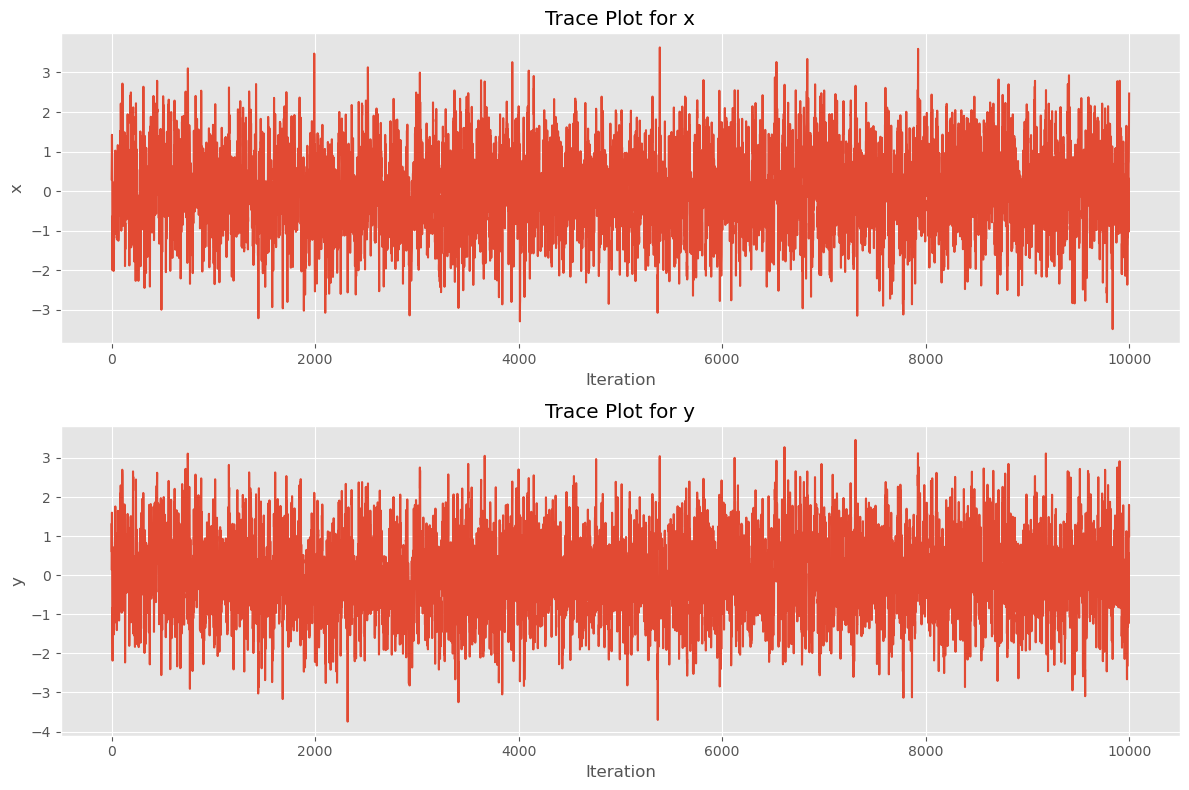

In [20]:
# Trace plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(samples_gibbs[:, 0])
plt.title('Trace Plot for x')
plt.xlabel('Iteration')
plt.ylabel('x')

plt.subplot(2, 1, 2)
plt.plot(samples_gibbs[:, 1])
plt.title('Trace Plot for y')
plt.xlabel('Iteration')
plt.ylabel('y')

plt.tight_layout()
plt.show()

### Exercise

Run the Gibbs sampler with different correlation values (e.g., 0.0, 0.5, 0.9, -0.5). How does the correlation affect the shape of the joint distribution and the mixing of the chain?

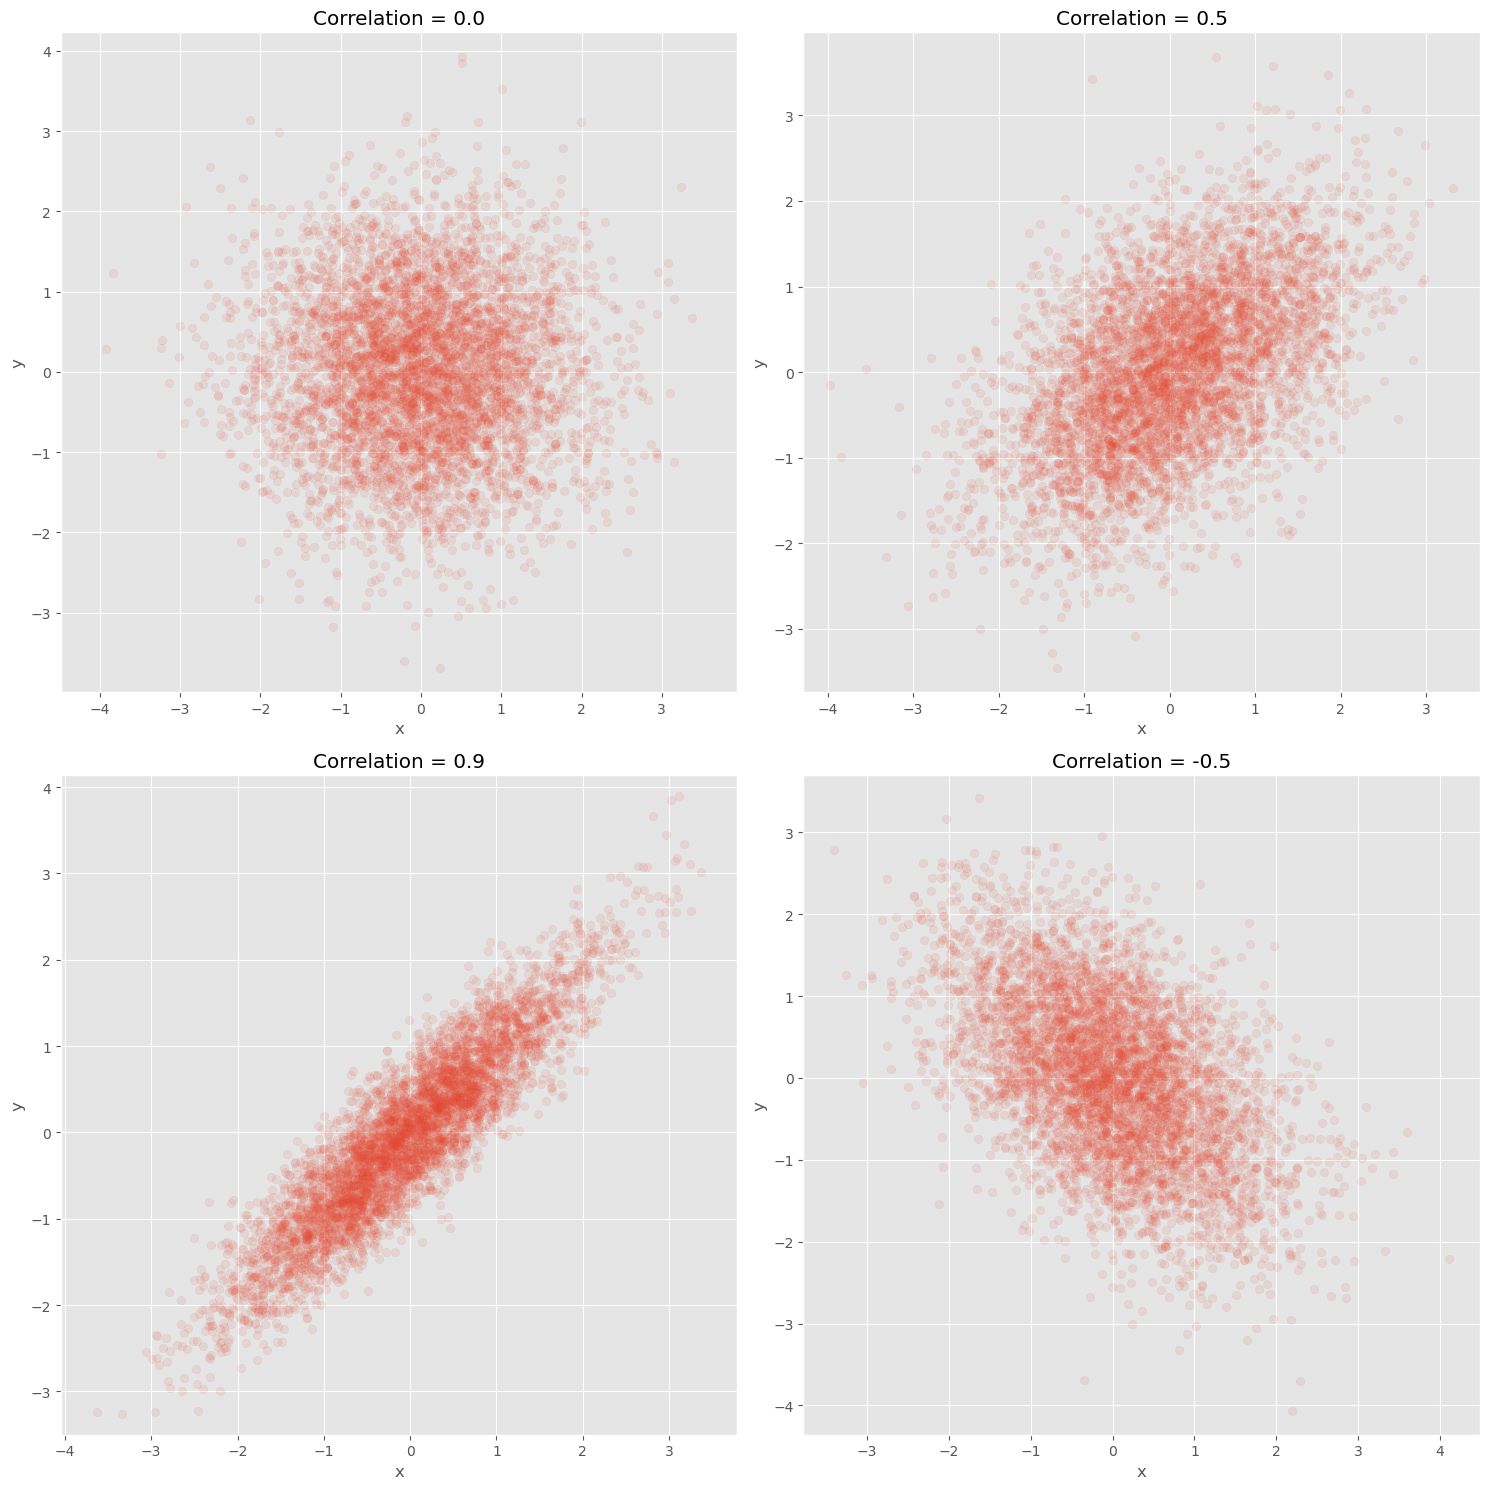

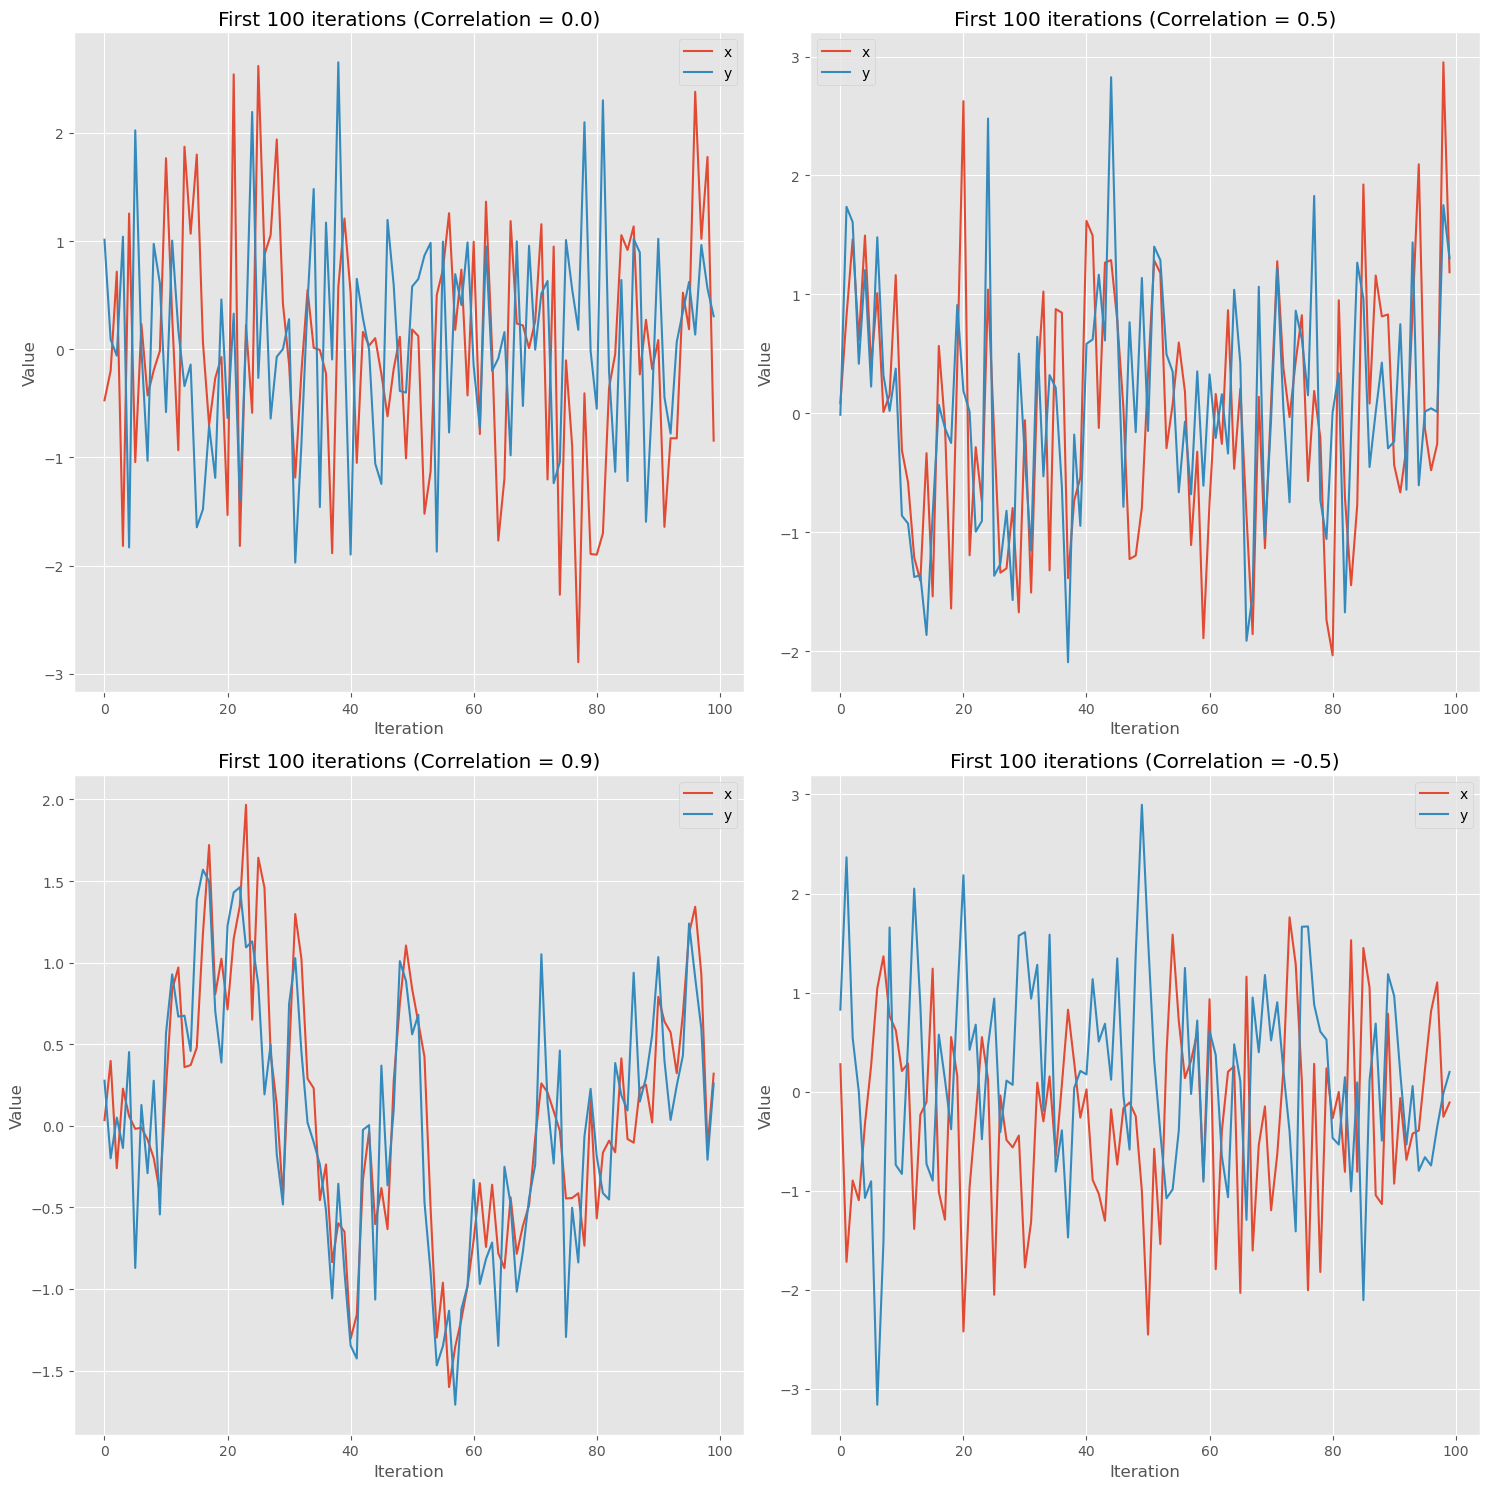

In [ ]:

correlations = [0.0, 0.5, 0.9, -0.5]
np.random.seed(42)

plt.figure(figsize=(15, 15))

# your code here
    # your code here
    
    # Scatter plot
    plt.subplot(2, 2, i+1)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
    plt.title(f'Correlation = {rho}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot trace plots for each correlation
plt.figure(figsize=(15, 15))

# your code here
    # your code here
    
    # First 100 iterations to see mixing behavior
    plt.subplot(2, 2, i+1)
    plt.plot(samples[:100, 0], label='x')
    plt.plot(samples[:100, 1], label='y')
    plt.title(f'First 100 iterations (Correlation = {rho})')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

## Useful tips for MCMC

Bayesian inference would be the *de facto* method if it weren't for MCMC's computational difficulties. In fact, MCMC is what turns most users off practical Bayesian inference. Below I present some good heuristics to help convergence and speed up the MCMC engine:

### Intelligent starting values

It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we *think* the posterior distribution will be by specifying the `testval` parameter in the `Stochastic` variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the $\mu$ parameter, then a good starting value would be the *mean* of the data. 

     mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )

For most parameters in models, there is a frequentist estimate of it. These estimates are a good starting value for our MCMC algorithms. Of course, this is not always possible for some variables, but including as many appropriate initial values is always a good idea. Even if your guesses are wrong, the MCMC will still converge to the proper distribution, so there is little to lose.

This is what using `MAP` tries to do, by giving good initial values to the MCMC. So why bother specifying user-defined values? Well, even giving `MAP` good values will help it find the maximum a-posterior. 

Also important, *bad initial values* are a source of major bugs in PyMC3 and can hurt convergence.

#### Priors

If the priors are poorly chosen, the MCMC algorithm may not converge, or atleast have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to carefully choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors (see *Folk Theorem of Statistical Computing* below). 

#### Covariance matrices and eliminating parameters

### The Folk Theorem of Statistical Computing

>   *If you are having computational problems, probably your model is wrong.*


## Conclusion

PyMC3 provides a very strong backend to performing Bayesian inference, mostly because it has abstracted the inner mechanics of MCMC from the user. Despite this, some care must be applied to ensure your inference is not being biased by the iterative nature of MCMC. 

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [25]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
